In [1]:
pip install wandb torch-fidelity

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import wandb
import shutil
from torch_fidelity import calculate_metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
config = {
    "dataset": "CIFAR-10",
    "batch_size": 128,
    "epochs_vqvae": 60,
    "epochs_pixelcnn": 100,
    "lr_vqvae": 2e-4,
    "lr_pixelcnn": 3e-4,
    "num_embeddings": 2048,
    "embedding_dim": 256,
    "commitment_cost": 0.15,
    "fid_every": 5,
    "fid_samples": 1000,
    "kid_subset_size": 300,
    "pixelcnn_layers": 25,
    "pixelcnn_hidden": 256,
    "temperature": 0.95,
}

run_name = f"VQ-VAE+PixelCNN_Final"

wandb.init(project="generative-modeling-on-cifar-10", name=run_name, config=config)

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.
wandb: Currently logged in as: gioeba (gioeba-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

real_folder = "/tmp/cifar10_real"
gen_folder = "/tmp/cifar10_gen"
os.makedirs(real_folder, exist_ok=True)
os.makedirs(gen_folder, exist_ok=True)

real_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=T.ToTensor())
if len(os.listdir(real_folder)) == 0:
    for i in tqdm(range(10000), desc="Saving real images"):
        img, _ = real_dataset[i]
        vutils.save_image(img, os.path.join(real_folder, f"real_{i}.png"))

In [5]:
real_test_folder = "/tmp/cifar10_test_real"
gen_test_folder  = "/tmp/cifar10_test_gen"

os.makedirs(real_test_folder, exist_ok=True)
os.makedirs(gen_test_folder, exist_ok=True)

test_real_ds = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

if len(os.listdir(real_test_folder)) == 0:
    print("Saving CIFAR-10 TEST real images...")
    for i in tqdm(range(len(test_real_ds))):
        img, _ = test_real_ds[i]
        vutils.save_image(img, os.path.join(real_test_folder, f"real_{i}.png"))
else:
    print("Real TEST images already exist, skipping.")

Real TEST images already exist, skipping.


In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 1)
        )

    def forward(self, x):
        return x + self.block(x)

In [7]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=[128, 256], latent_dim=256):
        super().__init__()
        layers = [nn.Conv2d(in_channels, hidden_channels[0], 4, stride=2, padding=1), nn.ReLU()]
        layers.append(nn.Conv2d(hidden_channels[0], hidden_channels[1], 4, stride=2, padding=1))
        layers.append(nn.ReLU())
        for _ in range(2):
            layers.append(ResidualBlock(hidden_channels[1]))
        layers.append(nn.Conv2d(hidden_channels[1], latent_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim=256, hidden_channels=[256, 128], out_channels=3):
        super().__init__()
        layers = [nn.Conv2d(latent_dim, hidden_channels[0], 3, padding=1)]
        for _ in range(2):
            layers.append(ResidualBlock(hidden_channels[0]))
        layers.append(nn.ConvTranspose2d(hidden_channels[0], hidden_channels[1], 4, stride=2, padding=1))
        layers.append(nn.ReLU())
        for _ in range(2):
            layers.append(ResidualBlock(hidden_channels[1]))
        layers.append(nn.ConvTranspose2d(hidden_channels[1], out_channels, 4, stride=2, padding=1))
        layers.append(nn.Tanh())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [8]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings=512, embedding_dim=256, beta=0.25):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.beta = beta

        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

    def forward(self, z):
        z_perm = z.permute(0, 2, 3, 1).contiguous()
        flat_z = z_perm.view(-1, self.embedding_dim)

        distances = (
            flat_z.pow(2).sum(1, keepdim=True)
            - 2 * flat_z @ self.embedding.weight.t()
            + self.embedding.weight.pow(2).sum(1)
        )

        indices = torch.argmin(distances, dim=1)
        z_q = self.embedding(indices).view(z_perm.shape)

        codebook_loss = F.mse_loss(z_q, z_perm.detach())
        commitment_loss = F.mse_loss(z_q.detach(), z_perm)
        vq_loss = codebook_loss + self.beta * commitment_loss

        z_q = z_perm + (z_q - z_perm).detach()

        encodings = F.one_hot(indices, self.num_embeddings).float()
        perplexity = torch.exp(-torch.sum(encodings.mean(0) * torch.log(encodings.mean(0) + 1e-10)))

        return z_q.permute(0, 3, 1, 2).contiguous(), vq_loss, perplexity, indices.view(z.size(0), z.size(2), z.size(3))

In [9]:
class VQVAE(nn.Module):
    def __init__(self, num_embeddings=512, embedding_dim=256, beta=0.25):
        super().__init__()
        self.encoder = Encoder(in_channels=3, hidden_channels=[128, 256], latent_dim=embedding_dim)
        self.vq = VectorQuantizer(num_embeddings, embedding_dim, beta)
        self.decoder = Decoder(latent_dim=embedding_dim, hidden_channels=[256, 128], out_channels=3)

    def forward(self, x):
        z = self.encoder(x)
        z_q, vq_loss, perplexity, indices = self.vq(z)
        x_recon = self.decoder(z_q)
        return x_recon, vq_loss, perplexity, indices

    def encode_to_indices(self, x):
        z = self.encoder(x)
        _, _, _, indices = self.vq(z)
        return indices

    def decode_from_indices(self, indices):
        z_q = self.vq.embedding(indices).permute(0, 3, 1, 2).contiguous()
        return self.decoder(z_q)

In [10]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer("mask", torch.ones_like(self.weight))
        kH,kW = self.kernel_size
        yc,xc = kH//2, kW//2
        self.mask[:,:,yc+1:,:] = 0
        self.mask[:,:,yc,xc+1:] = 0
        if mask_type=="A":
            self.mask[:,:,yc,xc]=0

    def forward(self, x):
        return F.conv2d(x, self.weight*self.mask, self.bias, self.stride, self.padding, self.dilation, self.groups)

class GatedResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = MaskedConv2d("B", dim, 2*dim, 3, padding=1)
        self.out = nn.Conv2d(dim, dim, 1)

    def forward(self, x):
        h = self.conv(F.relu(x))
        a,b = h.chunk(2, dim=1)
        h = torch.tanh(a) * torch.sigmoid(b)
        return x + self.out(h)

In [11]:
class PixelCNN(nn.Module):
    def __init__(self, num_embeddings, hidden_dim=256, num_layers=25):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding = nn.Embedding(num_embeddings, hidden_dim)
        self.input_conv = MaskedConv2d("A", hidden_dim, hidden_dim, 7, padding=3)
        self.blocks = nn.ModuleList([GatedResBlock(hidden_dim) for _ in range(num_layers)])
        self.output = nn.Sequential(nn.ReLU(), nn.Conv2d(hidden_dim, hidden_dim, 1),
                                    nn.ReLU(), nn.Conv2d(hidden_dim, num_embeddings, 1))

    def forward(self, x):
        x = self.embedding(x).permute(0,3,1,2)
        x = self.input_conv(x)
        for block in self.blocks:
            x = block(x)
        return self.output(x)

    @torch.no_grad()
    def sample(self, batch_size, spatial_size=8, device="cuda", temperature=0.95):
        samples = torch.zeros(batch_size, spatial_size, spatial_size, dtype=torch.long, device=device)
        for i in range(spatial_size):
            for j in range(spatial_size):
                logits = self(samples)[:,:,i,j] / temperature
                probs = F.softmax(logits, dim=1)
                samples[:,i,j] = torch.multinomial(probs,1).squeeze(-1)
        return samples

In [12]:
vqvae = VQVAE(config["num_embeddings"], config["embedding_dim"], config["commitment_cost"]).to(device)

optimizer_vqvae = torch.optim.Adam(vqvae.parameters(), lr=config["lr_vqvae"])

for epoch in range(1, config["epochs_vqvae"]+1):
    vqvae.train()
    total_loss = total_recon = total_vq = total_ppl = 0.0
    for x,_ in tqdm(train_loader, desc=f"VQ-VAE Epoch {epoch}/{config['epochs_vqvae']}"):
        x = x.to(device)
        optimizer_vqvae.zero_grad()
        x_recon, vq_loss, ppl, _ = vqvae(x)
        recon_loss = F.l1_loss(x_recon, x)
        loss = recon_loss + vq_loss
        loss.backward()
        optimizer_vqvae.step()
        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_vq += vq_loss.item()
        total_ppl += ppl.item()
    n = len(train_loader)
    wandb.log({"vqvae/epoch": epoch,
               "vqvae/total_loss": total_loss/n,
               "vqvae/recon_loss": total_recon/n,
               "vqvae/vq_loss": total_vq/n,
               "vqvae/perplexity": total_ppl/n}, step=epoch)
    print(f"Epoch {epoch:3d} | Loss {total_loss/n:.4f} | Recon {total_recon/n:.4f} | VQ {total_vq/n:.4f} | PPL {total_ppl/n:.1f}")

VQ-VAE Epoch 1/60: 100%|██████████| 390/390 [00:07<00:00, 54.56it/s]


Epoch   1 | Loss 128.3647 | Recon 0.2795 | VQ 128.0852 | PPL 2.5


VQ-VAE Epoch 2/60: 100%|██████████| 390/390 [00:06<00:00, 61.15it/s]


Epoch   2 | Loss 25.1335 | Recon 0.2237 | VQ 24.9098 | PPL 3.3


VQ-VAE Epoch 3/60: 100%|██████████| 390/390 [00:06<00:00, 59.35it/s]


Epoch   3 | Loss 12.5255 | Recon 0.2098 | VQ 12.3156 | PPL 4.3


VQ-VAE Epoch 4/60: 100%|██████████| 390/390 [00:06<00:00, 63.03it/s]


Epoch   4 | Loss 8.8766 | Recon 0.2020 | VQ 8.6746 | PPL 5.4


VQ-VAE Epoch 5/60: 100%|██████████| 390/390 [00:06<00:00, 62.55it/s]


Epoch   5 | Loss 8.8647 | Recon 0.1995 | VQ 8.6652 | PPL 5.3


VQ-VAE Epoch 6/60: 100%|██████████| 390/390 [00:06<00:00, 62.51it/s]


Epoch   6 | Loss 4.4857 | Recon 0.1917 | VQ 4.2940 | PPL 6.1


VQ-VAE Epoch 7/60: 100%|██████████| 390/390 [00:06<00:00, 60.97it/s]


Epoch   7 | Loss 1.7616 | Recon 0.1718 | VQ 1.5899 | PPL 8.3


VQ-VAE Epoch 8/60: 100%|██████████| 390/390 [00:06<00:00, 63.08it/s]


Epoch   8 | Loss 1.2804 | Recon 0.1664 | VQ 1.1140 | PPL 9.6


VQ-VAE Epoch 9/60: 100%|██████████| 390/390 [00:06<00:00, 61.69it/s]


Epoch   9 | Loss 1.0928 | Recon 0.1620 | VQ 0.9308 | PPL 11.1


VQ-VAE Epoch 10/60: 100%|██████████| 390/390 [00:06<00:00, 60.73it/s]


Epoch  10 | Loss 0.8711 | Recon 0.1562 | VQ 0.7149 | PPL 13.1


VQ-VAE Epoch 11/60: 100%|██████████| 390/390 [00:06<00:00, 60.76it/s]


Epoch  11 | Loss 0.8029 | Recon 0.1512 | VQ 0.6517 | PPL 14.8


VQ-VAE Epoch 12/60: 100%|██████████| 390/390 [00:06<00:00, 63.80it/s]


Epoch  12 | Loss 0.7430 | Recon 0.1473 | VQ 0.5958 | PPL 15.7


VQ-VAE Epoch 13/60: 100%|██████████| 390/390 [00:06<00:00, 61.24it/s]


Epoch  13 | Loss 0.6805 | Recon 0.1433 | VQ 0.5372 | PPL 16.7


VQ-VAE Epoch 14/60: 100%|██████████| 390/390 [00:06<00:00, 58.44it/s]


Epoch  14 | Loss 0.6222 | Recon 0.1395 | VQ 0.4828 | PPL 18.2


VQ-VAE Epoch 15/60: 100%|██████████| 390/390 [00:06<00:00, 61.44it/s]


Epoch  15 | Loss 0.5776 | Recon 0.1363 | VQ 0.4413 | PPL 19.6


VQ-VAE Epoch 16/60: 100%|██████████| 390/390 [00:06<00:00, 61.62it/s]


Epoch  16 | Loss 0.5373 | Recon 0.1328 | VQ 0.4045 | PPL 20.9


VQ-VAE Epoch 17/60: 100%|██████████| 390/390 [00:06<00:00, 57.39it/s]


Epoch  17 | Loss 0.5118 | Recon 0.1303 | VQ 0.3815 | PPL 22.2


VQ-VAE Epoch 18/60: 100%|██████████| 390/390 [00:06<00:00, 61.46it/s]


Epoch  18 | Loss 0.4855 | Recon 0.1275 | VQ 0.3581 | PPL 24.0


VQ-VAE Epoch 19/60: 100%|██████████| 390/390 [00:06<00:00, 62.09it/s]


Epoch  19 | Loss 0.4632 | Recon 0.1250 | VQ 0.3382 | PPL 25.6


VQ-VAE Epoch 20/60: 100%|██████████| 390/390 [00:06<00:00, 62.03it/s]


Epoch  20 | Loss 0.4445 | Recon 0.1231 | VQ 0.3214 | PPL 27.0


VQ-VAE Epoch 21/60: 100%|██████████| 390/390 [00:06<00:00, 62.53it/s]


Epoch  21 | Loss 0.4263 | Recon 0.1210 | VQ 0.3053 | PPL 28.4


VQ-VAE Epoch 22/60: 100%|██████████| 390/390 [00:06<00:00, 59.35it/s]


Epoch  22 | Loss 0.4133 | Recon 0.1196 | VQ 0.2937 | PPL 29.7


VQ-VAE Epoch 23/60: 100%|██████████| 390/390 [00:06<00:00, 63.98it/s]


Epoch  23 | Loss 0.4031 | Recon 0.1181 | VQ 0.2850 | PPL 31.0


VQ-VAE Epoch 24/60: 100%|██████████| 390/390 [00:06<00:00, 60.52it/s]


Epoch  24 | Loss 0.3979 | Recon 0.1166 | VQ 0.2812 | PPL 32.1


VQ-VAE Epoch 25/60: 100%|██████████| 390/390 [00:06<00:00, 62.56it/s]


Epoch  25 | Loss 0.3934 | Recon 0.1153 | VQ 0.2781 | PPL 33.2


VQ-VAE Epoch 26/60: 100%|██████████| 390/390 [00:06<00:00, 61.04it/s]


Epoch  26 | Loss 0.3904 | Recon 0.1140 | VQ 0.2764 | PPL 34.3


VQ-VAE Epoch 27/60: 100%|██████████| 390/390 [00:06<00:00, 64.91it/s]


Epoch  27 | Loss 0.3859 | Recon 0.1129 | VQ 0.2730 | PPL 35.4


VQ-VAE Epoch 28/60: 100%|██████████| 390/390 [00:06<00:00, 60.79it/s]


Epoch  28 | Loss 0.3805 | Recon 0.1117 | VQ 0.2688 | PPL 36.2


VQ-VAE Epoch 29/60: 100%|██████████| 390/390 [00:06<00:00, 61.31it/s]


Epoch  29 | Loss 0.3762 | Recon 0.1106 | VQ 0.2656 | PPL 36.8


VQ-VAE Epoch 30/60: 100%|██████████| 390/390 [00:06<00:00, 62.33it/s]


Epoch  30 | Loss 0.3740 | Recon 0.1097 | VQ 0.2642 | PPL 37.4


VQ-VAE Epoch 31/60: 100%|██████████| 390/390 [00:06<00:00, 61.32it/s]


Epoch  31 | Loss 0.3722 | Recon 0.1089 | VQ 0.2633 | PPL 38.0


VQ-VAE Epoch 32/60: 100%|██████████| 390/390 [00:06<00:00, 61.08it/s]


Epoch  32 | Loss 0.3704 | Recon 0.1083 | VQ 0.2621 | PPL 38.7


VQ-VAE Epoch 33/60: 100%|██████████| 390/390 [00:06<00:00, 61.68it/s]


Epoch  33 | Loss 0.3705 | Recon 0.1076 | VQ 0.2629 | PPL 39.4


VQ-VAE Epoch 34/60: 100%|██████████| 390/390 [00:06<00:00, 63.32it/s]


Epoch  34 | Loss 0.3721 | Recon 0.1068 | VQ 0.2652 | PPL 40.1


VQ-VAE Epoch 35/60: 100%|██████████| 390/390 [00:06<00:00, 60.82it/s]


Epoch  35 | Loss 0.3751 | Recon 0.1062 | VQ 0.2689 | PPL 40.7


VQ-VAE Epoch 36/60: 100%|██████████| 390/390 [00:06<00:00, 59.26it/s]


Epoch  36 | Loss 0.3759 | Recon 0.1057 | VQ 0.2702 | PPL 41.2


VQ-VAE Epoch 37/60: 100%|██████████| 390/390 [00:06<00:00, 59.04it/s]


Epoch  37 | Loss 0.3763 | Recon 0.1049 | VQ 0.2714 | PPL 42.0


VQ-VAE Epoch 38/60: 100%|██████████| 390/390 [00:06<00:00, 60.29it/s]


Epoch  38 | Loss 0.3754 | Recon 0.1044 | VQ 0.2710 | PPL 42.7


VQ-VAE Epoch 39/60: 100%|██████████| 390/390 [00:06<00:00, 63.67it/s]


Epoch  39 | Loss 0.3747 | Recon 0.1038 | VQ 0.2709 | PPL 43.2


VQ-VAE Epoch 40/60: 100%|██████████| 390/390 [00:06<00:00, 64.01it/s]


Epoch  40 | Loss 0.3743 | Recon 0.1033 | VQ 0.2709 | PPL 43.6


VQ-VAE Epoch 41/60: 100%|██████████| 390/390 [00:06<00:00, 60.86it/s]


Epoch  41 | Loss 0.3736 | Recon 0.1029 | VQ 0.2707 | PPL 44.0


VQ-VAE Epoch 42/60: 100%|██████████| 390/390 [00:06<00:00, 62.72it/s]


Epoch  42 | Loss 0.3738 | Recon 0.1025 | VQ 0.2713 | PPL 44.3


VQ-VAE Epoch 43/60: 100%|██████████| 390/390 [00:06<00:00, 59.82it/s]


Epoch  43 | Loss 0.3734 | Recon 0.1021 | VQ 0.2713 | PPL 44.6


VQ-VAE Epoch 44/60: 100%|██████████| 390/390 [00:06<00:00, 62.47it/s]


Epoch  44 | Loss 0.3734 | Recon 0.1017 | VQ 0.2717 | PPL 45.0


VQ-VAE Epoch 45/60: 100%|██████████| 390/390 [00:06<00:00, 60.23it/s]


Epoch  45 | Loss 0.3730 | Recon 0.1012 | VQ 0.2717 | PPL 45.2


VQ-VAE Epoch 46/60: 100%|██████████| 390/390 [00:06<00:00, 64.51it/s]


Epoch  46 | Loss 0.3724 | Recon 0.1010 | VQ 0.2715 | PPL 45.5


VQ-VAE Epoch 47/60: 100%|██████████| 390/390 [00:06<00:00, 60.66it/s]


Epoch  47 | Loss 0.3709 | Recon 0.1007 | VQ 0.2702 | PPL 45.7


VQ-VAE Epoch 48/60: 100%|██████████| 390/390 [00:06<00:00, 64.02it/s]


Epoch  48 | Loss 0.3707 | Recon 0.1004 | VQ 0.2703 | PPL 46.0


VQ-VAE Epoch 49/60: 100%|██████████| 390/390 [00:06<00:00, 60.96it/s]


Epoch  49 | Loss 0.3712 | Recon 0.1001 | VQ 0.2711 | PPL 46.2


VQ-VAE Epoch 50/60: 100%|██████████| 390/390 [00:06<00:00, 62.55it/s]


Epoch  50 | Loss 0.3708 | Recon 0.0999 | VQ 0.2709 | PPL 46.5


VQ-VAE Epoch 51/60: 100%|██████████| 390/390 [00:06<00:00, 62.90it/s]


Epoch  51 | Loss 0.3720 | Recon 0.0995 | VQ 0.2725 | PPL 46.8


VQ-VAE Epoch 52/60: 100%|██████████| 390/390 [00:06<00:00, 60.63it/s]


Epoch  52 | Loss 0.3723 | Recon 0.0992 | VQ 0.2730 | PPL 47.1


VQ-VAE Epoch 53/60: 100%|██████████| 390/390 [00:06<00:00, 61.45it/s]


Epoch  53 | Loss 0.3723 | Recon 0.0990 | VQ 0.2733 | PPL 47.4


VQ-VAE Epoch 54/60: 100%|██████████| 390/390 [00:06<00:00, 61.29it/s]


Epoch  54 | Loss 0.3725 | Recon 0.0988 | VQ 0.2738 | PPL 47.7


VQ-VAE Epoch 55/60: 100%|██████████| 390/390 [00:06<00:00, 59.44it/s]


Epoch  55 | Loss 0.3730 | Recon 0.0985 | VQ 0.2744 | PPL 48.1


VQ-VAE Epoch 56/60: 100%|██████████| 390/390 [00:06<00:00, 60.80it/s]


Epoch  56 | Loss 0.3729 | Recon 0.0982 | VQ 0.2747 | PPL 48.5


VQ-VAE Epoch 57/60: 100%|██████████| 390/390 [00:06<00:00, 62.69it/s]


Epoch  57 | Loss 0.3720 | Recon 0.0979 | VQ 0.2741 | PPL 48.9


VQ-VAE Epoch 58/60: 100%|██████████| 390/390 [00:06<00:00, 58.94it/s]


Epoch  58 | Loss 0.3710 | Recon 0.0977 | VQ 0.2733 | PPL 49.3


VQ-VAE Epoch 59/60: 100%|██████████| 390/390 [00:06<00:00, 61.21it/s]


Epoch  59 | Loss 0.3702 | Recon 0.0975 | VQ 0.2727 | PPL 49.5


VQ-VAE Epoch 60/60: 100%|██████████| 390/390 [00:06<00:00, 59.83it/s]

Epoch  60 | Loss 0.3703 | Recon 0.0974 | VQ 0.2729 | PPL 49.7


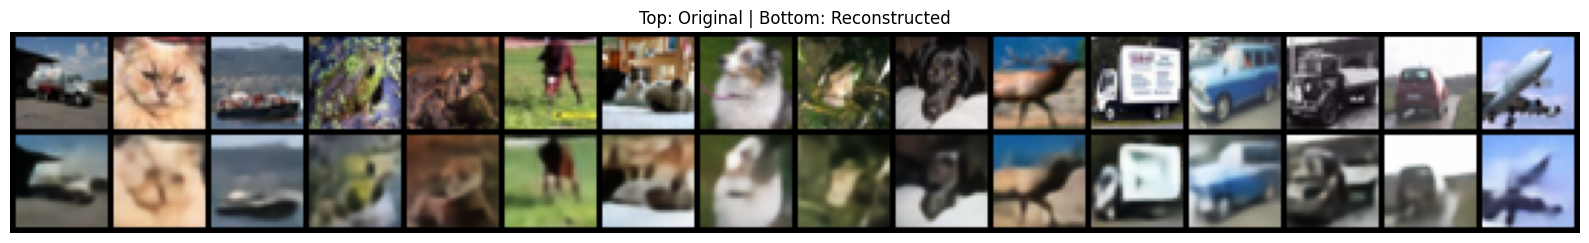

In [13]:
vqvae.eval()
with torch.no_grad():
    x, _ = next(iter(train_loader))
    x = x.to(device)
    x_recon, _, _, _ = vqvae(x)

grid = vutils.make_grid(
    torch.cat([x[:16], x_recon[:16]]),
    nrow=16,
    padding=2,
    normalize=True,
)

wandb.log({
    "vqvae/reconstructions": wandb.Image(
        grid.permute(1, 2, 0).cpu().numpy(),
        caption="Top: Original | Bottom: Reconstructed"
    )
})

plt.figure(figsize=(16, 4))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.title("Top: Original | Bottom: Reconstructed")
plt.tight_layout()
plt.show()

In [14]:
pixelcnn = PixelCNN(
    config["num_embeddings"],
    hidden_dim=config["pixelcnn_hidden"],
    num_layers=config["pixelcnn_layers"]
).to(device)

optimizer_pixelcnn = torch.optim.Adam(pixelcnn.parameters(), lr=config["lr_pixelcnn"])
fid_scores = []
kid_scores = []
epochs_list = []

vqvae.eval()

for epoch in range(1, config["epochs_pixelcnn"]+1):
    pixelcnn.train()
    total_loss = 0.0

    for x,_ in tqdm(train_loader, desc=f"PixelCNN Epoch {epoch}/{config['epochs_pixelcnn']}"):
        x = x.to(device)

        with torch.no_grad():
            indices = vqvae.encode_to_indices(x)

        optimizer_pixelcnn.zero_grad()
        logits = pixelcnn(indices)
        logits = logits.permute(0,2,3,1).contiguous()
        loss = F.cross_entropy(logits.view(-1, config["num_embeddings"]), indices.view(-1))
        loss.backward()
        optimizer_pixelcnn.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    wandb.log({"pixelcnn/epoch": epoch,
               "pixelcnn/loss": avg_loss,
               "pixelcnn/nll": avg_loss}, step=config["epochs_vqvae"] + epoch)
    print(f"Epoch {epoch:3d} | Loss {avg_loss:.4f}")

    if epoch % config["fid_every"] == 0:
        pixelcnn.eval()
        vqvae.eval()

        if os.path.exists(gen_folder):
            shutil.rmtree(gen_folder)
        os.makedirs(gen_folder, exist_ok=True)

        with torch.no_grad():
            idx = 0
            while idx < config["fid_samples"]:
                cur_bs = min(64, config["fid_samples"] - idx)
                sampled_indices = pixelcnn.sample(batch_size=cur_bs, spatial_size=8, device=device, temperature=config["temperature"])
                imgs = vqvae.decode_from_indices(sampled_indices)
                imgs = (imgs + 1)/2
                imgs = imgs.clamp(0, 1)

                for j in range(imgs.size(0)):
                    vutils.save_image(imgs[j], os.path.join(gen_folder, f"{idx}.png"))
                    idx += 1

        metrics = calculate_metrics(
            input1=gen_folder,
            input2=real_folder,
            fid=True,
            kid=True,
            kid_subset_size=config["kid_subset_size"]
        )

        fid = metrics["frechet_inception_distance"]
        kid = metrics["kernel_inception_distance_mean"]

        fid_scores.append(fid)
        kid_scores.append(kid)
        epochs_list.append(epoch)

        wandb.log({"metrics/FID": fid, "metrics/KID": kid}, step=config["epochs_vqvae"] + epoch)
        print(f"→ FID: {fid:.2f} | KID: {kid:.5f}")

PixelCNN Epoch 1/100: 100%|██████████| 390/390 [00:14<00:00, 27.64it/s]


Epoch   1 | Loss 3.4767


PixelCNN Epoch 2/100: 100%|██████████| 390/390 [00:13<00:00, 27.97it/s]


Epoch   2 | Loss 3.2689


PixelCNN Epoch 3/100: 100%|██████████| 390/390 [00:13<00:00, 27.93it/s]


Epoch   3 | Loss 3.2225


PixelCNN Epoch 4/100: 100%|██████████| 390/390 [00:13<00:00, 27.93it/s]


Epoch   4 | Loss 3.1883


PixelCNN Epoch 5/100: 100%|██████████| 390/390 [00:13<00:00, 27.92it/s]


Epoch   5 | Loss 3.1579


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
/usr/local/lib/python3.12/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 112.07243376182225
Kernel Inception Distance: 0.08676924228668213 ± 0.00482332638706853


→ FID: 112.07 | KID: 0.08677


PixelCNN Epoch 6/100: 100%|██████████| 390/390 [00:13<00:00, 28.06it/s]


Epoch   6 | Loss 3.1297


PixelCNN Epoch 7/100: 100%|██████████| 390/390 [00:14<00:00, 27.66it/s]


Epoch   7 | Loss 3.1012


PixelCNN Epoch 8/100: 100%|██████████| 390/390 [00:14<00:00, 27.49it/s]


Epoch   8 | Loss 3.0699


PixelCNN Epoch 9/100: 100%|██████████| 390/390 [00:14<00:00, 27.29it/s]


Epoch   9 | Loss 3.0340


PixelCNN Epoch 10/100: 100%|██████████| 390/390 [00:13<00:00, 27.99it/s]


Epoch  10 | Loss 2.9923


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 109.78145399972982
Kernel Inception Distance: 0.08398924350738525 ± 0.003748118995106245


→ FID: 109.78 | KID: 0.08399


PixelCNN Epoch 11/100: 100%|██████████| 390/390 [00:14<00:00, 27.09it/s]


Epoch  11 | Loss 2.9421


PixelCNN Epoch 12/100: 100%|██████████| 390/390 [00:13<00:00, 27.94it/s]


Epoch  12 | Loss 2.8813


PixelCNN Epoch 13/100: 100%|██████████| 390/390 [00:14<00:00, 27.14it/s]


Epoch  13 | Loss 2.8105


PixelCNN Epoch 14/100: 100%|██████████| 390/390 [00:14<00:00, 27.77it/s]


Epoch  14 | Loss 2.7289


PixelCNN Epoch 15/100: 100%|██████████| 390/390 [00:14<00:00, 27.74it/s]


Epoch  15 | Loss 2.6364


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 107.72787320229247
Kernel Inception Distance: 0.0800859785079956 ± 0.0037650932510018232


→ FID: 107.73 | KID: 0.08009


PixelCNN Epoch 16/100: 100%|██████████| 390/390 [00:14<00:00, 27.04it/s]


Epoch  16 | Loss 2.5344


PixelCNN Epoch 17/100: 100%|██████████| 390/390 [00:14<00:00, 27.63it/s]


Epoch  17 | Loss 2.4267


PixelCNN Epoch 18/100: 100%|██████████| 390/390 [00:13<00:00, 27.87it/s]


Epoch  18 | Loss 2.3139


PixelCNN Epoch 19/100: 100%|██████████| 390/390 [00:13<00:00, 27.94it/s]


Epoch  19 | Loss 2.2014


PixelCNN Epoch 20/100: 100%|██████████| 390/390 [00:14<00:00, 27.80it/s]


Epoch  20 | Loss 2.0851


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 106.38304253285963
Kernel Inception Distance: 0.07991147756576539 ± 0.004175796484800271


→ FID: 106.38 | KID: 0.07991


PixelCNN Epoch 21/100: 100%|██████████| 390/390 [00:14<00:00, 27.61it/s]


Epoch  21 | Loss 1.9738


PixelCNN Epoch 22/100: 100%|██████████| 390/390 [00:13<00:00, 28.04it/s]


Epoch  22 | Loss 1.8664


PixelCNN Epoch 23/100: 100%|██████████| 390/390 [00:13<00:00, 27.92it/s]


Epoch  23 | Loss 1.7638


PixelCNN Epoch 24/100: 100%|██████████| 390/390 [00:13<00:00, 27.94it/s]


Epoch  24 | Loss 1.6638


PixelCNN Epoch 25/100: 100%|██████████| 390/390 [00:14<00:00, 27.10it/s]


Epoch  25 | Loss 1.5743


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 104.34639858019415
Kernel Inception Distance: 0.07055209398269653 ± 0.003338890897656346


→ FID: 104.35 | KID: 0.07055


PixelCNN Epoch 26/100: 100%|██████████| 390/390 [00:14<00:00, 26.84it/s]


Epoch  26 | Loss 1.4924


PixelCNN Epoch 27/100: 100%|██████████| 390/390 [00:13<00:00, 27.95it/s]


Epoch  27 | Loss 1.4098


PixelCNN Epoch 28/100: 100%|██████████| 390/390 [00:14<00:00, 27.26it/s]


Epoch  28 | Loss 1.3362


PixelCNN Epoch 29/100: 100%|██████████| 390/390 [00:14<00:00, 27.76it/s]


Epoch  29 | Loss 1.2738


PixelCNN Epoch 30/100: 100%|██████████| 390/390 [00:14<00:00, 27.60it/s]


Epoch  30 | Loss 1.2118


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 115.25701681564612
Kernel Inception Distance: 0.09329350233078003 ± 0.004539318852189991


→ FID: 115.26 | KID: 0.09329


PixelCNN Epoch 31/100: 100%|██████████| 390/390 [00:14<00:00, 27.18it/s]


Epoch  31 | Loss 1.1525


PixelCNN Epoch 32/100: 100%|██████████| 390/390 [00:13<00:00, 28.00it/s]


Epoch  32 | Loss 1.1076


PixelCNN Epoch 33/100: 100%|██████████| 390/390 [00:14<00:00, 27.49it/s]


Epoch  33 | Loss 1.0627


PixelCNN Epoch 34/100: 100%|██████████| 390/390 [00:14<00:00, 27.42it/s]


Epoch  34 | Loss 1.0188


PixelCNN Epoch 35/100: 100%|██████████| 390/390 [00:13<00:00, 28.10it/s]


Epoch  35 | Loss 0.9800


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 104.87397265557831
Kernel Inception Distance: 0.07497294664382935 ± 0.00415541785257951


→ FID: 104.87 | KID: 0.07497


PixelCNN Epoch 36/100: 100%|██████████| 390/390 [00:14<00:00, 27.64it/s]


Epoch  36 | Loss 0.9440


PixelCNN Epoch 37/100: 100%|██████████| 390/390 [00:14<00:00, 27.48it/s]


Epoch  37 | Loss 0.9174


PixelCNN Epoch 38/100: 100%|██████████| 390/390 [00:14<00:00, 27.62it/s]


Epoch  38 | Loss 0.8844


PixelCNN Epoch 39/100: 100%|██████████| 390/390 [00:14<00:00, 27.57it/s]


Epoch  39 | Loss 0.8575


PixelCNN Epoch 40/100: 100%|██████████| 390/390 [00:13<00:00, 28.12it/s]


Epoch  40 | Loss 0.8382


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 107.70426451314398
Kernel Inception Distance: 0.0811095643043518 ± 0.003841040211243959


→ FID: 107.70 | KID: 0.08111


PixelCNN Epoch 41/100: 100%|██████████| 390/390 [00:14<00:00, 27.74it/s]


Epoch  41 | Loss 0.8124


PixelCNN Epoch 42/100: 100%|██████████| 390/390 [00:14<00:00, 27.43it/s]


Epoch  42 | Loss 0.7928


PixelCNN Epoch 43/100: 100%|██████████| 390/390 [00:14<00:00, 27.79it/s]


Epoch  43 | Loss 0.7695


PixelCNN Epoch 44/100: 100%|██████████| 390/390 [00:13<00:00, 27.92it/s]


Epoch  44 | Loss 0.7572


PixelCNN Epoch 45/100: 100%|██████████| 390/390 [00:14<00:00, 26.94it/s]


Epoch  45 | Loss 0.7369


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 106.6474613975094
Kernel Inception Distance: 0.07855209827423096 ± 0.004088770344857319


→ FID: 106.65 | KID: 0.07855


PixelCNN Epoch 46/100: 100%|██████████| 390/390 [00:14<00:00, 27.80it/s]


Epoch  46 | Loss 0.7193


PixelCNN Epoch 47/100: 100%|██████████| 390/390 [00:14<00:00, 27.19it/s]


Epoch  47 | Loss 0.7068


PixelCNN Epoch 48/100: 100%|██████████| 390/390 [00:14<00:00, 27.63it/s]


Epoch  48 | Loss 0.6961


PixelCNN Epoch 49/100: 100%|██████████| 390/390 [00:14<00:00, 27.76it/s]


Epoch  49 | Loss 0.6820


PixelCNN Epoch 50/100: 100%|██████████| 390/390 [00:14<00:00, 27.78it/s]


Epoch  50 | Loss 0.6673


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 100.71646565448577
Kernel Inception Distance: 0.07101320266723633 ± 0.00396195916699395


→ FID: 100.72 | KID: 0.07101


PixelCNN Epoch 51/100: 100%|██████████| 390/390 [00:14<00:00, 27.48it/s]


Epoch  51 | Loss 0.6597


PixelCNN Epoch 52/100: 100%|██████████| 390/390 [00:13<00:00, 27.94it/s]


Epoch  52 | Loss 0.6426


PixelCNN Epoch 53/100: 100%|██████████| 390/390 [00:14<00:00, 27.31it/s]


Epoch  53 | Loss 0.6368


PixelCNN Epoch 54/100: 100%|██████████| 390/390 [00:14<00:00, 27.68it/s]


Epoch  54 | Loss 0.6307


PixelCNN Epoch 55/100: 100%|██████████| 390/390 [00:14<00:00, 26.91it/s]


Epoch  55 | Loss 0.6185


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 105.31901752875547
Kernel Inception Distance: 0.07879496097564698 ± 0.00369456607270932


→ FID: 105.32 | KID: 0.07879


PixelCNN Epoch 56/100: 100%|██████████| 390/390 [00:14<00:00, 27.09it/s]


Epoch  56 | Loss 0.6145


PixelCNN Epoch 57/100: 100%|██████████| 390/390 [00:13<00:00, 27.87it/s]


Epoch  57 | Loss 0.6000


PixelCNN Epoch 58/100: 100%|██████████| 390/390 [00:14<00:00, 27.75it/s]


Epoch  58 | Loss 0.5936


PixelCNN Epoch 59/100: 100%|██████████| 390/390 [00:13<00:00, 27.86it/s]


Epoch  59 | Loss 0.5903


PixelCNN Epoch 60/100: 100%|██████████| 390/390 [00:14<00:00, 27.48it/s]


Epoch  60 | Loss 0.5833


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 105.44543358588265
Kernel Inception Distance: 0.07966724872589111 ± 0.003942386490089849


→ FID: 105.45 | KID: 0.07967


PixelCNN Epoch 61/100: 100%|██████████| 390/390 [00:14<00:00, 27.32it/s]


Epoch  61 | Loss 0.5743


PixelCNN Epoch 62/100: 100%|██████████| 390/390 [00:13<00:00, 28.01it/s]


Epoch  62 | Loss 0.5673


PixelCNN Epoch 63/100: 100%|██████████| 390/390 [00:14<00:00, 27.03it/s]


Epoch  63 | Loss 0.5624


PixelCNN Epoch 64/100: 100%|██████████| 390/390 [00:13<00:00, 28.07it/s]


Epoch  64 | Loss 0.5565


PixelCNN Epoch 65/100: 100%|██████████| 390/390 [00:13<00:00, 27.93it/s]


Epoch  65 | Loss 0.5540


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 104.84444295574622
Kernel Inception Distance: 0.07443531036376953 ± 0.0032418289702442937


→ FID: 104.84 | KID: 0.07444


PixelCNN Epoch 66/100: 100%|██████████| 390/390 [00:14<00:00, 26.41it/s]


Epoch  66 | Loss 0.5467


PixelCNN Epoch 67/100: 100%|██████████| 390/390 [00:13<00:00, 27.91it/s]


Epoch  67 | Loss 0.5450


PixelCNN Epoch 68/100: 100%|██████████| 390/390 [00:14<00:00, 27.79it/s]


Epoch  68 | Loss 0.5408


PixelCNN Epoch 69/100: 100%|██████████| 390/390 [00:14<00:00, 27.73it/s]


Epoch  69 | Loss 0.5281


PixelCNN Epoch 70/100: 100%|██████████| 390/390 [00:14<00:00, 27.42it/s]


Epoch  70 | Loss 0.5216


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 113.46604942267106
Kernel Inception Distance: 0.09293523073196411 ± 0.004649958307747852


→ FID: 113.47 | KID: 0.09294


PixelCNN Epoch 71/100: 100%|██████████| 390/390 [00:14<00:00, 27.38it/s]


Epoch  71 | Loss 0.5238


PixelCNN Epoch 72/100: 100%|██████████| 390/390 [00:14<00:00, 27.59it/s]


Epoch  72 | Loss 0.5235


PixelCNN Epoch 73/100: 100%|██████████| 390/390 [00:14<00:00, 27.34it/s]


Epoch  73 | Loss 0.5179


PixelCNN Epoch 74/100: 100%|██████████| 390/390 [00:13<00:00, 28.06it/s]


Epoch  74 | Loss 0.5078


PixelCNN Epoch 75/100: 100%|██████████| 390/390 [00:13<00:00, 27.86it/s]


Epoch  75 | Loss 0.5071


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 104.15997943774994
Kernel Inception Distance: 0.07246676445007325 ± 0.0037804252494665594


→ FID: 104.16 | KID: 0.07247


PixelCNN Epoch 76/100: 100%|██████████| 390/390 [00:14<00:00, 27.27it/s]


Epoch  76 | Loss 0.5033


PixelCNN Epoch 77/100: 100%|██████████| 390/390 [00:14<00:00, 27.80it/s]


Epoch  77 | Loss 0.5004


PixelCNN Epoch 78/100: 100%|██████████| 390/390 [00:14<00:00, 27.76it/s]


Epoch  78 | Loss 0.4955


PixelCNN Epoch 79/100: 100%|██████████| 390/390 [00:13<00:00, 27.95it/s]


Epoch  79 | Loss 0.4960


PixelCNN Epoch 80/100: 100%|██████████| 390/390 [00:14<00:00, 27.80it/s]


Epoch  80 | Loss 0.4894


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 106.2757477730508
Kernel Inception Distance: 0.08284417152404785 ± 0.003982709541231643


→ FID: 106.28 | KID: 0.08284


PixelCNN Epoch 81/100: 100%|██████████| 390/390 [00:14<00:00, 26.94it/s]


Epoch  81 | Loss 0.4850


PixelCNN Epoch 82/100: 100%|██████████| 390/390 [00:13<00:00, 27.97it/s]


Epoch  82 | Loss 0.4837


PixelCNN Epoch 83/100: 100%|██████████| 390/390 [00:14<00:00, 27.52it/s]


Epoch  83 | Loss 0.4859


PixelCNN Epoch 84/100: 100%|██████████| 390/390 [00:14<00:00, 27.59it/s]


Epoch  84 | Loss 0.4765


PixelCNN Epoch 85/100: 100%|██████████| 390/390 [00:14<00:00, 27.58it/s]


Epoch  85 | Loss 0.4763


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 103.62571301285953
Kernel Inception Distance: 0.07634294509887696 ± 0.003978705643063122


→ FID: 103.63 | KID: 0.07634


PixelCNN Epoch 86/100: 100%|██████████| 390/390 [00:14<00:00, 27.41it/s]


Epoch  86 | Loss 0.4764


PixelCNN Epoch 87/100: 100%|██████████| 390/390 [00:13<00:00, 27.93it/s]


Epoch  87 | Loss 0.4688


PixelCNN Epoch 88/100: 100%|██████████| 390/390 [00:13<00:00, 28.03it/s]


Epoch  88 | Loss 0.4677


PixelCNN Epoch 89/100: 100%|██████████| 390/390 [00:14<00:00, 27.81it/s]


Epoch  89 | Loss 0.4610


PixelCNN Epoch 90/100: 100%|██████████| 390/390 [00:14<00:00, 27.29it/s]


Epoch  90 | Loss 0.4646


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 102.47945670892443
Kernel Inception Distance: 0.07319414615631104 ± 0.004092574529999764


→ FID: 102.48 | KID: 0.07319


PixelCNN Epoch 91/100: 100%|██████████| 390/390 [00:14<00:00, 27.49it/s]


Epoch  91 | Loss 0.4638


PixelCNN Epoch 92/100: 100%|██████████| 390/390 [00:14<00:00, 27.30it/s]


Epoch  92 | Loss 0.4575


PixelCNN Epoch 93/100: 100%|██████████| 390/390 [00:13<00:00, 27.89it/s]


Epoch  93 | Loss 0.4548


PixelCNN Epoch 94/100: 100%|██████████| 390/390 [00:14<00:00, 27.83it/s]


Epoch  94 | Loss 0.4515


PixelCNN Epoch 95/100: 100%|██████████| 390/390 [00:14<00:00, 27.46it/s]


Epoch  95 | Loss 0.4513


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 105.45744074995582
Kernel Inception Distance: 0.08045031547546387 ± 0.004435186450339403


→ FID: 105.46 | KID: 0.08045


PixelCNN Epoch 96/100: 100%|██████████| 390/390 [00:14<00:00, 27.34it/s]


Epoch  96 | Loss 0.4490


PixelCNN Epoch 97/100: 100%|██████████| 390/390 [00:14<00:00, 27.54it/s]


Epoch  97 | Loss 0.4493


PixelCNN Epoch 98/100: 100%|██████████| 390/390 [00:14<00:00, 27.54it/s]


Epoch  98 | Loss 0.4431


PixelCNN Epoch 99/100: 100%|██████████| 390/390 [00:13<00:00, 27.90it/s]


Epoch  99 | Loss 0.4448


PixelCNN Epoch 100/100: 100%|██████████| 390/390 [00:13<00:00, 28.00it/s]


Epoch 100 | Loss 0.4452


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 106.40085840319466
                                                                                 

→ FID: 106.40 | KID: 0.07750


Kernel Inception Distance: 0.07749653339385987 ± 0.0041359039350151415


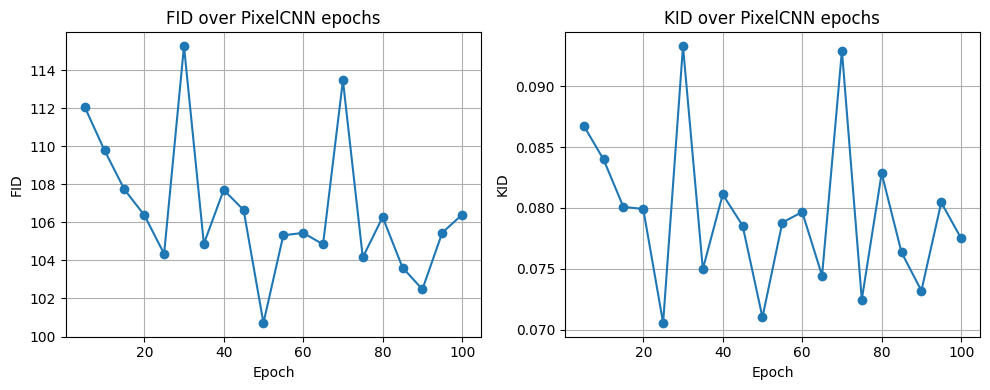

<Figure size 640x480 with 0 Axes>

In [15]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs_list, fid_scores, marker="o")
plt.title("FID over PixelCNN epochs")
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs_list, kid_scores, marker="o")
plt.title("KID over PixelCNN epochs")
plt.xlabel("Epoch")
plt.ylabel("KID")
plt.grid(True)

plt.tight_layout()
plt.show()

wandb.log({"FID_KID_curves": wandb.Image(plt.gcf())})

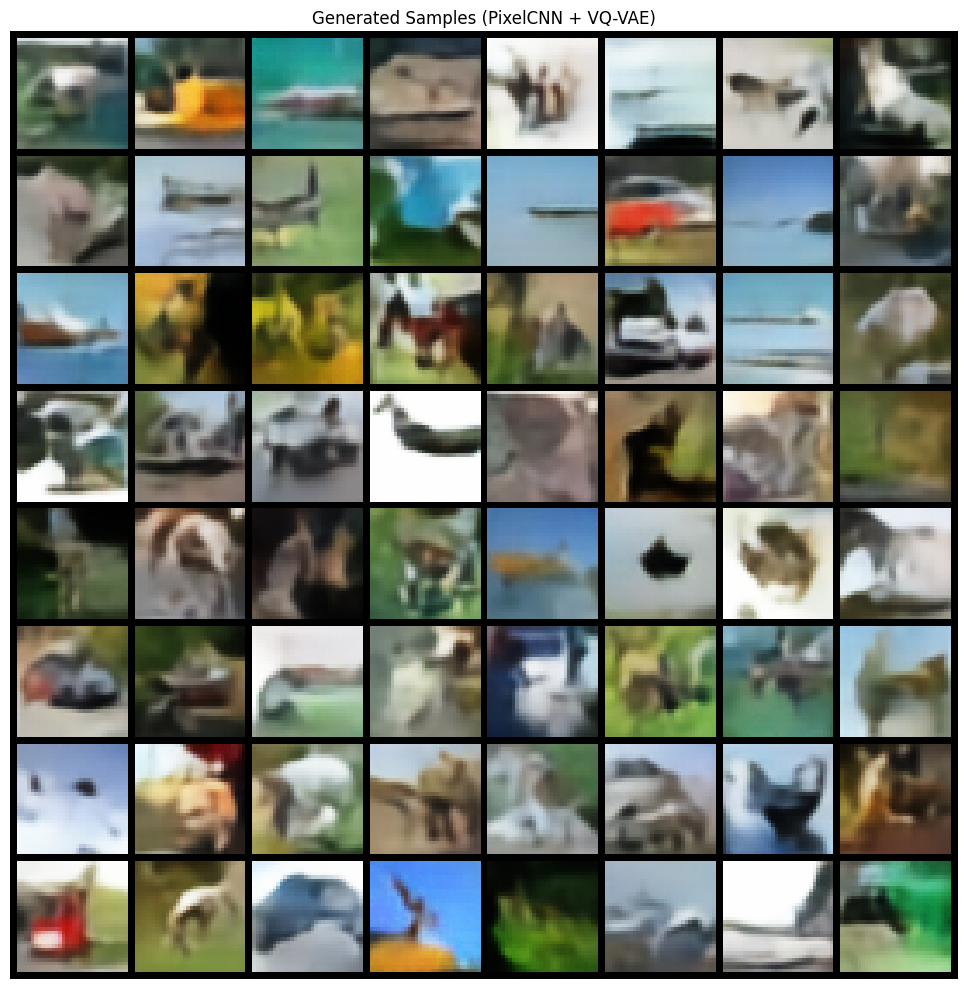

In [16]:
pixelcnn.eval()
vqvae.eval()

with torch.no_grad():
    sampled_indices = pixelcnn.sample(batch_size=64, spatial_size=8, device=device, temperature=config["temperature"])
    generated_images = vqvae.decode_from_indices(sampled_indices)
    generated_images = (generated_images + 1)/2
    generated_images = generated_images.clamp(0, 1)

grid = vutils.make_grid(generated_images, nrow=8, padding=2)

wandb.log({"samples/generated": wandb.Image(grid.permute(1,2,0).cpu().numpy(),
                                            caption=f"Generated with T={config['temperature']}")})

plt.figure(figsize=(10,10))
plt.imshow(grid.permute(1,2,0).cpu())
plt.axis("off")
plt.title("Generated Samples (PixelCNN + VQ-VAE)")
plt.tight_layout()
plt.show()

In [17]:
pixelcnn.eval()
vqvae.eval()

if os.path.exists(gen_test_folder):
    shutil.rmtree(gen_test_folder)
os.makedirs(gen_test_folder, exist_ok=True)

n_samples = 1000
bs = 64
spatial_size = 8
temperature = config["temperature"]

idx = 0
with torch.no_grad():
    while idx < n_samples:
        cur_bs = min(bs, n_samples - idx)

        sampled_indices = pixelcnn.sample(
            batch_size=cur_bs,
            spatial_size=spatial_size,
            device=device,
            temperature=temperature
        )

        imgs = vqvae.decode_from_indices(sampled_indices)
        imgs = (imgs + 1) / 2
        imgs = imgs.clamp(0, 1)

        for j in range(imgs.size(0)):
            vutils.save_image(imgs[j], os.path.join(gen_test_folder, f"{idx}.png"))
            idx += 1

print("Generated:", idx, "samples into", gen_test_folder)

Generated: 1000 samples into /tmp/cifar10_test_gen


In [18]:
metrics = calculate_metrics(
    input1=gen_test_folder,
    input2=real_test_folder,
    fid=True,
    kid=True,
    kid_subset_size=300,
)

fid = float(metrics["frechet_inception_distance"])
kid = float(metrics["kernel_inception_distance_mean"])

print(f"TEST FID: {fid:.2f}")
print(f"TEST KID: {kid:.6f}")

wandb.log({
    "test/FID": fid,
    "test/KID": kid,
})
wandb.finish()


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_test_gen" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_test_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 103.02455792603143
                                                                                 

TEST FID: 103.02
TEST KID: 0.073743


Kernel Inception Distance: 0.07374328374862671 ± 0.0038632226698523888


metrics/FID,▆▅▄▄▃█▃▄▄▁▃▃▃▇▃▄▂▂▃▄
metrics/KID,▆▅▄▄▁█▂▄▃▁▄▄▂█▂▅▃▂▄▃
pixelcnn/epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
pixelcnn/loss,█▇▇▇▇▆▅▅▅▅▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pixelcnn/nll,████▇▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/FID,▁
test/KID,▁
vqvae/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
vqvae/perplexity,▁▁▁▁▁▂▂▃▃▃▃▄▄▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
vqvae/recon_loss,█▆▅▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+2,...
